# Grid

A tutorial on grid classes, its properties and transformations.

### Content
* [Geometries](#Geometries)
* [Basic properties](#Basic-properties)
* [Grid transformations](#Grid-transformations)
    * [Minimal cube](#Minimal-cube)
    * [Rescale](#Rescale)
    * [Orthogonalization](#Orthogonalization)
    * [Corner-point representation](#Corner-point-representation)
    * [Local grid](#Local-grid)

## Geometries

Grid supports 2 geometry types:
* `OrthogonalUniformGrid`
* `CornerPointGrid`

By default, grid is attributed to `CornerPointGrid` if the model contains both 'ZCORN' and 'COORD' keywords.

In this notebook we will work with corner-point grid attributes (working with orthogonal grids is very similar). To speed up loading one can specify required components and attributes using `config` parameter of the `Field`. Here we use default config for the CornerPointGrid:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield import Field, corn_grid_config
from deepfield.field.plot_utils import plot_bounds_3d, plot_bounds_2d

corn_grid_config

{'CornerPointGrid': {'attrs': ['ACTNUM',
   'COORD',
   'DIMENS',
   'MAPAXES',
   'ZCORN'],
  'apply_mapaxes': True}}

Load grid attributes only:

In [2]:
model = Field(path='../open_data/norne_simplified/norne_simplified.data',
              config=corn_grid_config).load()

INFO:Field:Start reading norne_simplified.data
INFO:Field:[norne_simplified.data:3] Loading TITLE
INFO:Field:[norne_simplified.data:9] Loading START
INFO:Field:[norne_simplified.data:13] Loading METRIC
INFO:Field:[norne_simplified.data:14] Loading OIL
INFO:Field:[norne_simplified.data:15] Loading GAS
INFO:Field:[norne_simplified.data:16] Loading WATER
INFO:Field:[norne_simplified.data:17] Loading DISGAS
INFO:Field:[norne_simplified.data:19] Loading DIMENS
INFO:Field:[norne_simplified.data:33] Include C:\Users\E.Illarionov\Desktop\DP\geology\open_data\norne_simplified\INCLUDE\zcorn.inc
INFO:Field:Start reading zcorn.inc
INFO:Field:[zcorn.inc:1] Loading ZCORN
INFO:Field:Finish reading zcorn.inc
INFO:Field:[norne_simplified.data:37] Include C:\Users\E.Illarionov\Desktop\DP\geology\open_data\norne_simplified\INCLUDE\coord.inc
INFO:Field:Start reading coord.inc
INFO:Field:[coord.inc:1] Loading COORD
INFO:Field:Finish reading coord.inc
INFO:Field:[norne_simplified.data:41] Include C:\Users\E

INFO:Field:[schedule.inc:1329] Loading DATES
INFO:Field:[schedule.inc:1340] Loading DATES
INFO:Field:[schedule.inc:1358] Loading DATES
INFO:Field:[schedule.inc:1388] Loading DATES
INFO:Field:[schedule.inc:1407] Loading DATES
INFO:Field:[schedule.inc:1426] Loading DATES
INFO:Field:[schedule.inc:1444] Loading DATES
INFO:Field:[schedule.inc:1459] Loading DATES
INFO:Field:[schedule.inc:1487] Loading DATES
INFO:Field:[schedule.inc:1506] Loading DATES
INFO:Field:[schedule.inc:1540] Loading DATES
INFO:Field:[schedule.inc:1558] Loading DATES
INFO:Field:[schedule.inc:1575] Loading DATES
INFO:Field:[schedule.inc:1592] Loading DATES
INFO:Field:[schedule.inc:1610] Loading DATES
INFO:Field:[schedule.inc:1632] Loading DATES
INFO:Field:[schedule.inc:1677] Loading DATES
INFO:Field:[schedule.inc:1695] Loading DATES
INFO:Field:[schedule.inc:1713] Loading DATES
INFO:Field:[schedule.inc:1731] Loading DATES
INFO:Field:[schedule.inc:1764] Loading DATES
INFO:Field:[schedule.inc:1782] Loading DATES
INFO:Field

INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, DIMENS, ZCORN, COORD, ACTNUM
INFO:Field:=========================
INFO:Field:Grid pillars (`COORD`) are mapped to new axis with respect to `MAPAXES`.


## Basic properties

List of grid attributes

In [3]:
model.grid.attributes

('MAPAXES', 'DIMENS', 'ZCORN', 'COORD', 'ACTNUM')

Grid dimensions

In [4]:
model.grid.dimens

array([ 46, 112,  22])

Note that loaded arrays are in a spatial shape by default: 

In [5]:
model.grid.actnum.shape

(46, 112, 22)

Method `ravel` transforms all spatial arrays into a ravel shape:

In [6]:
model.grid.ravel()

model.grid.actnum.shape, model.grid.zcorn.shape

((113344,), (906752,))

while `to_spatial` transforms them back into a spatial shape:

In [7]:
model.grid.to_spatial()

model.grid.actnum.shape, model.grid.zcorn.shape

((46, 112, 22), (46, 112, 22, 8))

Grid location with respect to map coordinates and unit vectors in x and y grid directions can be obtained as follows:

In [8]:
model.grid.origin, model.grid.ex, model.grid.ey

(array([   0.    ,    0.    , 3037.4729]), array([1., 0.]), array([0., 1.]))

Attribute `cell_centroinds` gives coordinates of cell centres. Let's get a center of the first cell:

In [9]:
model.grid.cell_centroids[0, 0, 0]

array([4.53215789e+05, 7.32000899e+06, 3.04003159e+03])

Each cell is defined by 8 corners and property `xyz` contains the coordinates. For example, coordinates of the first cell are

In [10]:
model.grid.xyz[0, 0, 0]

array([[4.53114000e+05, 7.31992100e+06, 3.03747290e+03],
       [4.53155031e+05, 7.31984000e+06, 2.98393311e+03],
       [4.53273188e+05, 7.32018000e+06, 3.06804492e+03],
       [4.53321312e+05, 7.32009450e+06, 3.06212988e+03],
       [4.53114000e+05, 7.31992100e+06, 3.03953101e+03],
       [4.53154623e+05, 7.31984080e+06, 2.99024097e+03],
       [4.53273099e+05, 7.32017984e+06, 3.07218799e+03],
       [4.53321063e+05, 7.32009481e+06, 3.06671191e+03]])

Propetry `cell_volumes` provides cell volumes, e.g. for the first cell we have

In [11]:
model.grid.cell_volumes[0, 0, 0]

112955.74164065154

Next we consider grid transformations.

## Grid transformations

### Minimal cube

Quite often active cells occupy only a small region within a grid. It might be useful to crop mininal region that contains active cells. The most simple way is to apply `crop_minimal_active_cube`. It finds minimal slices that contain active cells. The output grid has smaller dimensions:

In [12]:
min_grid, min_slices = model.grid.crop_minimal_cube()
min_grid.dimens, min_slices

(array([36, 92, 22]),
 (slice(5, 41, None), slice(10, 102, None), slice(0, 22, None)))

In [13]:
min_grid.dimens

array([36, 92, 22])

### Rescale

Orthogonal grids can be upscaled and downscaled, for corner point grids only upscaling is well defined. Parameter `factors` specifices scaling factor along each axis. Additional parameter `actnum_upscale` specifies how to transfer active cell into the new grid:

In [14]:
up_grid = model.grid.upscale(factors=(4, 4, 5), actnum_upscale='vote')
print('Original:', model.grid.dimens, 'Upscaled:', up_grid.dimens)

Original: [ 46 112  22] Upscaled: [11 28  4]


Dowscaling is implmented for orthogonal grids only.

### Orthogonalization

Corner point grid can be orthogonalized with respect to the bounding box of the corner point grid:

In [15]:
model.grid.bounding_box

array([[4.53114000e+05, 7.31583550e+06, 2.23026001e+03],
       [4.65658625e+05, 7.33111950e+06, 3.50841309e+03]])

Create a new orthogonal grid:

In [16]:
ort_grid = model.grid.orthogonalize(dimens=(10, 12, 14))
ort_grid.dimens

(10, 12, 14)

Note that grid origin coincides with the bounding box corner:

In [17]:
ort_grid.origin == model.grid.bounding_box[0]

array([ True,  True,  True])

Grid axes coincide with map axes: 

In [18]:
ort_grid.ex, ort_grid.ey

(array([1., 0.]), array([0., 1.]))

### Corner-point representation

Orthoronal grid has a natural corner-point representation:

In [19]:
ort_grid.as_corner_point.attributes

('DIMENS', 'MAPAXES', 'ZCORN', 'COORD')

A new instance can be obtained as

In [20]:
ort_grid.to_corner_point()

### Local grid

Local grid is a corner point grid that is bounded by upper and lower active cell surfaces and splits the space between in a given number of layers. This can be useful to get a grid with reduced number of inactive cells. The only parameter required is a target resolution along z-axis:

In [21]:
grid, grid_mask, z_top, z_bottom = model.grid.crop_minimal_grid(nz=10)
print("Local grid dimens:", grid.dimens)

Local grid dimens: [ 46 112  10]


Next figure shows top and bottom bounds of the local grid

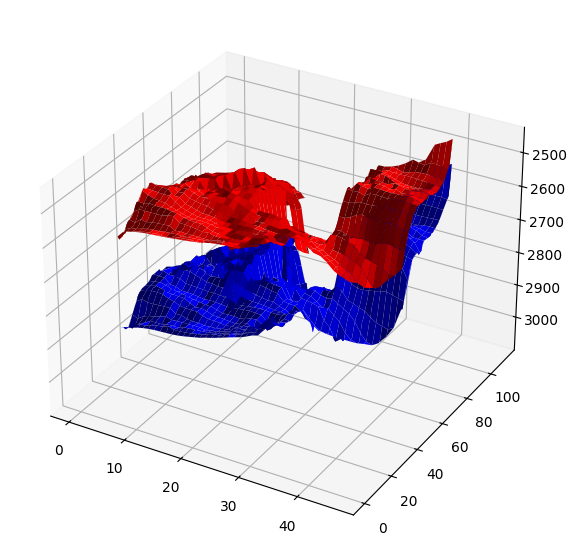

In [22]:
plot_bounds_3d(z_top, z_bottom, figsize=(9, 7))

The same bounds in 2d projections (to active an interactive mode set `x=None` and `y=None`):

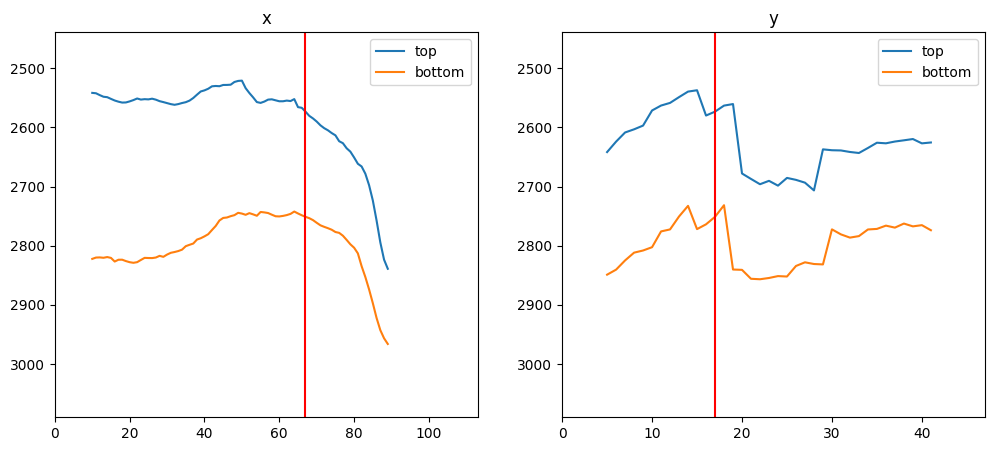

In [23]:
plot_bounds_2d(z_top, z_bottom, x=17, y=67, figsize=(12, 5))

At this point we interrupt the story about the `Grid` class and invite you to the next tutorials.